# 102 Spark optimizations

The goal of this lab is to understand some of the optimization mechanisms of Spark.

- Scala
    - [Spark programming guide](https://spark.apache.org/docs/latest/rdd-programming-guide.html)
    - [RDD APIs](https://spark.apache.org/docs/latest/api/scala/org/apache/spark/rdd/RDD.html)
    - [PairRDD APIs](https://spark.apache.org/docs/latest/api/scala/org/apache/spark/rdd/PairRDDFunctions.html)
- Python
    - [Spark programming guide](https://spark.apache.org/docs/3.5.0/rdd-programming-guide.html)
    - [All RDD APIs](https://spark.apache.org/docs/3.5.0/api/python/reference/api/pyspark.RDD.html)

Use `Tab` for autocompletion, `Shift+Tab` for documentation.

In [2]:
from pyspark.sql import SparkSession

# .master("local[N]") <-- ask for N cores on the driver
spark = SparkSession.builder \
.master("local[8]") \
.appName("Local Spark") \
.config('spark.ui.port', '4040') \
  .getOrCreate()
sc = spark.sparkContext

sc

<SparkContext master=local[8] appName=Local Spark>

## The weather dataset

Download the following ZIP files and unzip them inside the "datasets/big" folder of this repo (which is not committed).
- [weather-sample1.txt](https://big.csr.unibo.it/downloads/bigdata/weather-datasets-s1.zip) <-- start from this!
- [weather-sample10.txt](https://big.csr.unibo.it/downloads/bigdata/weather-datasets-s10.zip)
- [weather-full.txt](https://big.csr.unibo.it/downloads/bigdata/weather-datasets-full.zip)
  
The weather datasets are textual files with weather data from all over the world in year 2000 (collected from the [National Climatic Data Center](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/) of the USA. The full one weighs 13GB, the other are samples of 10% (1.3GB) and 1% (130MB) respectively.
  - Sample row: 005733213099999**19580101**03004+51317+028783FM-12+017199999V0203201N00721004501CN0100001N9 **-0021**1-01391102681
  - The date in YYYYMMDD format is located at 0-based position 15-23
  - The temperatue in x10 Celsius degrees is located at 0-based positions 87-92

In the dataset folder you also have *weather-stations.csv*; it is a structured file with the description of weather stations collecting the weather data.

In [3]:
# WEATHER structure: (usaf,wban,year,month,day,airTemperature,airTemperatureQuality)
def parseWeather(row):
    usaf = row[4:10]
    wban = row[10:15]
    year = row[15:19]
    month = row[19:21]
    day = row[21:23]
    airTemperature = row[87:92]
    airTemperatureQuality = row[92]

    return (usaf,wban,year,month,day,int(airTemperature)/10,airTemperatureQuality == '1')

# STATION structure: (usaf,wban,city,country,state,latitude,longitude,elevation,date_begin,date_end) 
def parseStation(row):
    def getDouble(str):
        return 0 if len(str)==0 else float(str)
    
    columns = [ x.replace("\"","") for x in row.split(",") ]
    latitude = getDouble(columns[6])
    longitude = getDouble(columns[7])
    elevation = getDouble(columns[8])
    return (columns[0],columns[1],columns[2],columns[3],columns[4],latitude,longitude,elevation,columns[9],columns[10])  

In [4]:
rddWeather = sc.\
  textFile("../../../../datasets/big/weather-sample1.txt") \
    .map(lambda x: parseWeather(x))

rddStation = sc.\
  textFile("../../../../datasets/weather-stations.csv").\
  map(lambda x: parseStation(x))

## 102-1 Simple job optimization

Optimize the two jobs (avg temperature and max temperature) by avoiding the repetition of the same computations and by enforcing a partitioning criteria.
- There are multiple methods to repartition an RDD: check the ```coalesce```, ```partitionBy```, and ```repartition``` methods on the documentation and choose the best one.
- Verify your persisted data in the web UI
- Verify the execution plan of your RDDs with ```rdd.toDebugString``` (shell only) or on the web UI

In [7]:
# Average temperature for every month
rddWeather.\
  filter(lambda x: x[5]<999).\
  map(lambda x: (x[3], (x[5],1))).\
  reduceByKey(lambda v1, v2: (v1[0]+v2[0], v1[1]+v2[1])).\
  mapValues(lambda v: round(v[0]/v[1],2)).\
  collect()

[('09', 10.62),
 ('10', 8.58),
 ('01', 0.31),
 ('02', 0.41),
 ('05', 9.64),
 ('06', 11.95),
 ('12', 1.74),
 ('04', 4.91),
 ('07', 14.1),
 ('03', 1.89),
 ('08', 13.78),
 ('11', 4.38)]

In [8]:
# Maximum temperature for every month
rddWeather.\
  filter(lambda x : x[5]<999).\
  map(lambda x : (x[3], (x[5],1))).\
  reduceByKey(lambda x, y : y if x<y else x).\
  collect()

[('09', (30.0, 1)),
 ('10', (20.0, 1)),
 ('01', (12.0, 1)),
 ('02', (13.2, 1)),
 ('05', (34.2, 1)),
 ('06', (31.4, 1)),
 ('12', (14.0, 1)),
 ('04', (23.0, 1)),
 ('07', (29.2, 1)),
 ('03', (15.2, 1)),
 ('08', (23.0, 1)),
 ('11', (14.0, 1))]

## Optimizing jobs: avg temperature & max temperature

In [15]:
# rddWeather consists of tuples:
# (usaf, wban, year, month, day, airTemperature, airTemperatureQuality)
cachedRDD = (
    rddWeather
        .filter(lambda x : x[5]<999)
        .map(lambda x : (x[3], (x[5], 1))) # (month, (airTemperature, 1))
        # this shape is perfect for later reductions like:
        # - sum and count -> average temperature
        # - max temperature
        .partitionBy(8)
        # By calling .cache(), you tell Spark:
        # "When you compute this RDD once, keep it in memory so i can reuse it
        # later without recomputing
        .cache()
        # .cache() is useful here cause you need to reuse this filtered and 
        # partitioned RDD for both jobs
    )

In [19]:
# Average temperature for every month
(cachedRDD
    # reduceByKey signature:
    # reduceByKey(func, numPartitions)
    .reduceByKey(lambda v1, v2 : (v1[0]+v2[0], v1[1]+v2[1]), 1)
    # .mapValues() means: "Apply the function only to the values of the key-value
    # pairs, leaving the key unchanged"
    .mapValues(lambda v : round(v[0]/v[1], 2))
    .collect()
)

[('10', 8.58),
 ('02', 0.41),
 ('06', 11.95),
 ('07', 14.1),
 ('08', 13.78),
 ('11', 4.38),
 ('09', 10.62),
 ('01', 0.31),
 ('05', 9.64),
 ('12', 1.74),
 ('04', 4.91),
 ('03', 1.89)]

In [21]:
# Maximum temperature for every month
(cachedRDD
    .reduceByKey(lambda x,y : max(x,y), 1)
    .mapValues(lambda v : v[0])
    .collect()
)

[('10', 20.0),
 ('02', 13.2),
 ('06', 31.4),
 ('07', 29.2),
 ('08', 23.0),
 ('11', 14.0),
 ('09', 30.0),
 ('01', 12.0),
 ('05', 34.2),
 ('12', 14.0),
 ('04', 23.0),
 ('03', 15.2)]

Each RDD remembers how it was created, this is called its <b>lineage</b> or <b>execution plan</b>. It tells Spark how to recompute data if needed.

In [23]:
print(cachedRDD.toDebugString())

b'(8) MapPartitionsRDD[29] at mapPartitions at PythonRDD.scala:160 [Memory Serialized 1x Replicated]\n |       CachedPartitions: 8; MemorySize: 1738.5 KiB; DiskSize: 0.0 B\n |  ShuffledRDD[28] at partitionBy at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]\n +-(4) PairwiseRDD[27] at partitionBy at /tmp/ipykernel_128/2830821735.py:10 [Memory Serialized 1x Replicated]\n    |  PythonRDD[26] at partitionBy at /tmp/ipykernel_128/2830821735.py:10 [Memory Serialized 1x Replicated]\n    |  ../../../../datasets/big/weather-sample1.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]\n    |  ../../../../datasets/big/weather-sample1.txt HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 [Memory Serialized 1x Replicated]'


<b>How to read it</b>
- The numbers in parentheses → number of partitions (e.g., (8))
- Each line → a transformation
- The arrows ( | and +) → show dependencies (which RDDs feed into which)
- The bottom is the source (like your textFile read)
- The top is your final cached RDD

The Spark Web UI shows you everything about what’s happening inside Spark — it’s like your “dashboard” for performance and caching.<br>
<b>Step 1: Access the Web UI</b>
- Local mode: open: http://localhost:4040

<b>Step 2: Go to 'Storage' tab</b>: you'll see a table of all persisted/cached RDDs.

<b>Step 3: Check “Stages” and “Executors” tabs</b>
- Stages tab: shows DAG for each job
- Executors tab: shows memory and task distribution per executor



## 102-1 RDD preparation

Check the five possibilities to prepare the Station RDD for subsequent processing and identify the best one.

In [32]:
# rddStation consists of tuples:
# (usaf, wban, city, country, state, latitude, longitude, elevation, 
# date_begin, date_end) 
num_partitions = 8

# [0] and [1] are the fields composing the key; [3] and [7] are country and 
# elevation, respectively
rddS1 = rddStation.\
  keyBy(lambda x: x[0] + x[1]).\
  partitionBy(num_partitions).\
  cache().\
  map(lambda kv: (kv[0],(kv[1][3],kv[1][7])))
rddS2 = rddStation.\
  keyBy(lambda x: x[0] + x[1]).\
  map(lambda kv: (kv[0],(kv[1][3],kv[1][7]))).\
  cache().\
  partitionBy(num_partitions)
rddS3 = rddStation.\
  keyBy(lambda x: x[0] + x[1]).\
  partitionBy(num_partitions).\
  map(lambda kv: (kv[0],(kv[1][3],kv[1][7]))).\
  cache()
rddS4 = (
    rddStation.
        # This keyBy takes each fucntion and creates (key, value) pairs
        # - key = usaf + wban
        # - value = the original record (the whole tuple)
        keyBy(lambda x: x[0] + x[1])
        # from each (key, fullrecord) pair, build a new value with only:
        # - country = kv[1][3]
        # - elevation = kv[1][7]
        # (usaf + wban, (country, elevation))
        .map(lambda kv: (kv[0],(kv[1][3],kv[1][7])))
        # ensures all data for the same station stays together
        .partitionBy(num_partitions)
        .cache()
)
rddS5 = (
    rddStation
    .map(lambda x: (x[0] + x[1], (x[3],x[7])))
    .partitionBy(num_partitions)
    .cache()
)

- ```keyBy()``` and ```map()``` break the partitioning, thus they must be issued before ```partitionBy()```
- Anything that happens after ```cache()``` is not saved and must be recomputed each time; thus, it is good practice to cache() as later as possible
- rddS4 and rddS5 are the best options

## 103-3 Joinig RDDs
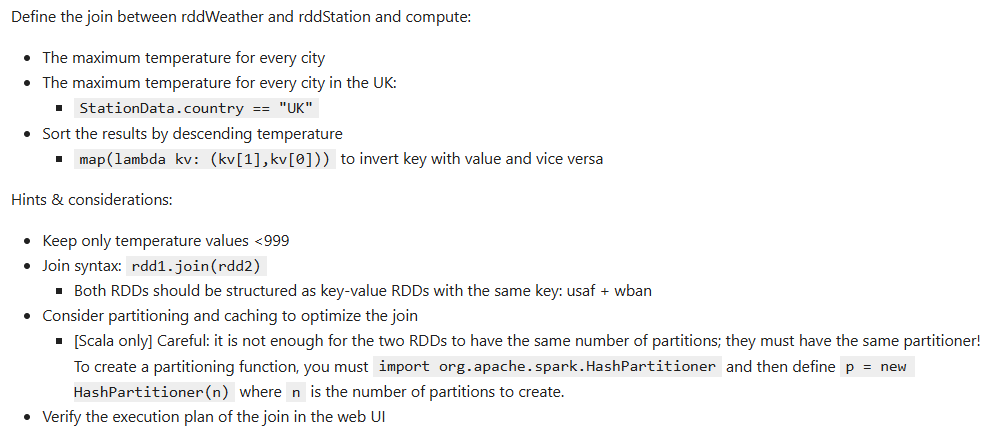

In [34]:
# Clear the cache 
# This removes any previously cached RDDs from memory. You do this to ensure 
# Spark recalculates everything cleanly for the new computation (avoiding 
# contamination from previous experiments). 
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()

In [49]:
# First version: caching the join
num_partitions = 8

# STATION structure:
# (usaf, wban, city, country, state, latitude, longitude, elevation, 
# date_begin, date_end)
rddS = (
    rddStation
    # - key = usaf + wban
    # - value = (city, country)
    .map(lambda s : (s[0]+s[1], (s[2], s[3])))
    .partitionBy(num_partitions)
)

# WEATHER structure:
# (usaf, wban, year, month, day, airTemperature, airTemperatureQuality)
rddW = (
    rddWeather
    .filter(lambda w : w[5]<999)
    # - key = usaf + wban
    # - value = temperature
    .map(lambda w : (w[0]+w[1], w[5]))
    .partitionBy(num_partitions)
)   

# Joins the two RDDs on their common key (usaf + wban).
# Because both are partitioned with the same partitioner, Spark does not 
# shuffle data → huge speed gain.
rddJoin = rddW.join(rddS).cache()
# (usaf + wban, (temperature, (city, country)))

# print(rddJoin.toDebugString().decode("unicode_escape"))
(rddJoin
    .map(lambda j : (j[1][1][0], j[1][0]))
    .reduceByKey(lambda x,y : max(x,y), 1)
    .collect()
)

[('OULU', 31.4),
 ('MUSTASAARI VALASSAARET', 20.2),
 ('MIKKELI', 28.0),
 ('SAVONLINNA', 30.0),
 ('KOTKA RANKKI', 25.3),
 ('ISOSAARI', 21.6),
 ('SCATSTA', 20.0),
 ('MUCKLE HOLM', 16.0),
 ('NORTH RONA ISLAND', 21.7),
 ('STORNOWAY', 20.0),
 ('LOCH GLASCARNOCH', 22.9),
 ('AULTBEA NO2', 23.0),
 ('HAILUOTO ISLAND', 28.6),
 ('VAASA', 27.0),
 ('AHTARI MYLLYMAKI', 28.9),
 ('KANKAANPAA NIINISALO PUOLVOIM', 29.4),
 ('HELSINKI VANTAA', 28.1),
 ('LEMLAND NYHAMN', 19.8),
 ('KUMLINGE ISLAND', 22.8),
 ('BENBECULA', 20.0),
 ('SOUTH UIST RANGE', 34.2),
 ('BARRA ISLAND', 21.0),
 ('KINLOSS', 24.0),
 ('GLENLIVET', 23.0),
 ('KRUUNUPYY', 28.0),
 ('INKOO BAGASKAR', 22.9),
 ('NIVALA', 28.7),
 ('SEINAJOKI', 28.0),
 ('JOENSUU', 30.0),
 ('TURKU', 27.1),
 ('PARAINEN UTO', 20.1),
 ('SUMBURGH', 30.0),
 ('SELLA NESS', 19.1),
 ('INVERGORDON HARBOUR', 20.8),
 ('AVIEMORE', 23.5),
 ('HALLI', 29.1),
 ('MARIEHAMN', 23.0),
 ('LERWICK', 17.9),
 ('FOULA', 15.9),
 ('FOULA NO2', 15.9),
 ('WATERSTEIN', 21.0),
 ('CAIRNGORM SUMMIT

In [51]:
# rddJoin: (usaf + wban, (temperature, (city, country)))
(rddJoin
    .filter(lambda j : j[1][1][1] == "UK")
    .map(lambda j : (j[1][1][0], j[1][0]))
    .reduceByKey(lambda x,y : max(x,y), 1)
     .collect()
)

[('SCATSTA', 20.0),
 ('MUCKLE HOLM', 16.0),
 ('NORTH RONA ISLAND', 21.7),
 ('STORNOWAY', 20.0),
 ('LOCH GLASCARNOCH', 22.9),
 ('AULTBEA NO2', 23.0),
 ('BENBECULA', 20.0),
 ('SOUTH UIST RANGE', 34.2),
 ('BARRA ISLAND', 21.0),
 ('KINLOSS', 24.0),
 ('GLENLIVET', 23.0),
 ('SUMBURGH', 30.0),
 ('SELLA NESS', 19.1),
 ('INVERGORDON HARBOUR', 20.8),
 ('AVIEMORE', 23.5),
 ('LERWICK', 17.9),
 ('FOULA', 15.9),
 ('FOULA NO2', 15.9),
 ('WATERSTEIN', 21.0),
 ('CAIRNGORM SUMMIT', 14.9),
 ('BALTASOUND NO.2', 18.0),
 ('FAIR ISLE', 15.7),
 ('NORTH RONALDSAY ISL', 6.9),
 ('BUTT OF LEWIS (LH)', 8.8),
 ('SKYE/LUSA', 23.4),
 ('ALTNAHARRA NO2', 24.1),
 ('RACKWICK', 19.6),
 ('FOYERS', 23.5),
 ('TAIN RANGE (SAWS)', 22.1),
 ('SULE SKERRY', 17.4),
 ('KIRKWALL', 19.0),
 ('LOCHBOISDALE', 21.0),
 ('KILMORY', 21.2),
 ('AONACH MOR', 17.4),
 ('TULLOCH BRIDGE', 26.0),
 ('INVERNESS', 23.0),
 ('LOSSIEMOUTH', 23.4)]

In [52]:
# Sort results by descending temperature
(rddJoin
    .filter(lambda j: j[1][1][1] == "UK")
    .map(lambda j: (j[1][1][0], j[1][0]))
    .reduceByKey(lambda x,y: min(x,y),1)
    .map(lambda kv: (kv[1],kv[0]))
    .sortByKey(False)
    .collect()
)

[(8.8, 'BUTT OF LEWIS (LH)'),
 (2.0, 'NORTH RONALDSAY ISL'),
 (1.4, 'SULE SKERRY'),
 (0.0, 'FOULA'),
 (-0.9, 'LOCHBOISDALE'),
 (-2.0, 'FAIR ISLE'),
 (-2.0, 'KILMORY'),
 (-2.5, 'BARRA ISLAND'),
 (-2.8, 'MUCKLE HOLM'),
 (-2.8, 'FOULA NO2'),
 (-3.1, 'SOUTH UIST RANGE'),
 (-3.4, 'AULTBEA NO2'),
 (-3.4, 'SKYE/LUSA'),
 (-3.5, 'NORTH RONA ISLAND'),
 (-3.8, 'INVERGORDON HARBOUR'),
 (-4.0, 'BENBECULA'),
 (-4.0, 'RACKWICK'),
 (-4.4, 'FOYERS'),
 (-4.5, 'KIRKWALL'),
 (-4.9, 'WATERSTEIN'),
 (-5.0, 'STORNOWAY'),
 (-5.0, 'SUMBURGH'),
 (-5.3, 'GLENLIVET'),
 (-5.3, 'SELLA NESS'),
 (-5.5, 'LERWICK'),
 (-6.0, 'KINLOSS'),
 (-6.9, 'TAIN RANGE (SAWS)'),
 (-7.0, 'SCATSTA'),
 (-7.0, 'LOCH GLASCARNOCH'),
 (-7.7, 'LOSSIEMOUTH'),
 (-8.0, 'INVERNESS'),
 (-9.4, 'BALTASOUND NO.2'),
 (-9.9, 'TULLOCH BRIDGE'),
 (-11.1, 'AVIEMORE'),
 (-11.2, 'AONACH MOR'),
 (-11.3, 'ALTNAHARRA NO2'),
 (-12.1, 'CAIRNGORM SUMMIT')]

## 103-4 Memory occupation

Use Spark's web UI to verify the space occupied by the provided RDDs.

*Warning*: in PySpark, StoraleLevels use serialization by default (see [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.StorageLevel.html)).

In [ ]:
from pyspark import StorageLevel

# Clear the cache
for (id, rdd) in sc._jsc.getPersistentRDDs().items():         
    rdd.unpersist()

memSerRdd = rddWeather.cache()
memRdd = memSerRdd.map(lambda x: x).persist(StorageLevel. MEMORY_AND_DISK_DESER)
diskRdd = memSerRdd.map(lambda x: x).persist(StorageLevel.DISK_ONLY)

## 102-5 Evaluating different join methods

Consider the following scenario:
- We have a disposable RDD of Weather data (i.e., it is used only once): ```rddW```
- And we have an RDD of Station data that is used many times: ```rddS```
- Both RDDs are cached (```collect()```is called to enforce caching)

We want to join the two RDDS. Which option is best?
- Simply join the two RDDs
- Enforce on ```rddW1``` the same partitioner of ```rddS``` (and then join)
- Exploit broadcast variables

In [ ]:
num_partitions = 8

rddW = rddWeather.\
  filter(lambda w: w[5]<999).\
  keyBy(lambda w: w[0]+w[1]).\
  cache()

rddS = rddStation.\
  keyBy(lambda s: s[0]+s[1]).\
  partitionBy(num_partitions).\
  cache()

# Collect to enforce caching
rddW.collect()
rddS.collect()

In [ ]:
# Is it better to simply join the two RDDs..
rddX = rddW.\
  join(rddS).\
  map(lambda kv: (kv[1][1][2],kv[1][0][5])).\
  reduceByKey(lambda x,y: min(x,y),1)
print(rddX.toDebugString().decode("unicode_escape"))

In [ ]:
rddX.collect()

In [ ]:
# ..to enforce on rddW1 the same partitioner of rddS..
rddX = rddW.\
  partitionBy(num_partitions).\
  join(rddS).\
  map(lambda kv: (kv[1][1][2],kv[1][0][5])).\
  reduceByKey(lambda x,y: min(x,y),1)
print(rddX.toDebugString().decode("unicode_escape"))

In [ ]:
rddX.collect()

In [ ]:
# ..or to exploit broadcast variables?
bRddS = sc.broadcast(rddS.map(lambda s: (s[0], s[1][2])).collectAsMap())
rddJ = rddW.\
  map(lambda kv: (bRddS.value.get(kv[0]), kv[1][5])).\
  filter(lambda x: x[0] is not None)

rddX = rddJ.\
  reduceByKey(lambda x,y: min(x,y),1)
print(rddX.toDebugString().decode("unicode_escape"))

In [ ]:
rddX.collect()